In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import seaborn as sns
from os import listdir, makedirs

In [2]:
# Data and figure path
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-2/data'
FORMATTED_DATA_PATH = '../data'
MODEL_RESULTS_PATH = '../../../human/exp_2/results/model_fits.csv'
FIG_PATH = '../figs'
makedirs(FIG_PATH, exist_ok=True)
makedirs(FORMATTED_DATA_PATH, exist_ok=True)

# If overwrite is True, will overwrite existing formatted data
OVERWRITE = False

# Subjects to exclude based on preregistered criterion
IDS_TO_EXCLUDE = [
    929094,
    297827,
    835395,
    123289,
    941076,
    786858,
    209368,
    385852,
    988204,
    586980
]

# Model colors
MODEL_COLORS = {
    'null': 'grey',
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}
MODEL_LABELS = {
    'null': 'Null',
    'ss': 'State',
    'ss-sampler': 'State (Sampler)',
    'ff': 'Feature'
}

In [3]:
FF_COLORS = {
    False: '#ffbdc6',
    True: '#FF2442'
}

# Load data

In [4]:
def information_from_label(model_label):
    """
    Get field information from model label

    Arguments
    ---------
    model_label : str
        model label
    
    Returns
    -------
    fields
    """
    fields = {}
    for field in model_label.split('_'):
        if not '-' in field:
            continue
        key, value = field.split('-')
        fields[key] = value
    return fields

def convert_state_str(state_str):
    """
    Convert a string representation of a state to a numpy array.

    Arguments
    ---------
    state_str : str
        The string representation of the state.

    Returns
    -------
    state_arr : numpy.ndarray
        The numpy array representation of the state
    """
    state_str = state_str.replace('[ ', '[').replace('  ', ' ')
    state_str = state_str[1:-1]
    state_str = state_str.split(' ')
    state_arr = np.array(state_str, dtype=int)
    return state_arr

def load_from_dir(path, phase):
    df = []
    for env_label in listdir(path):
        if env_label[0] == '.':
            continue
        for model_label in listdir(f'{path}/{env_label}'):
            if model_label[0] == '.':
                continue
            for f in listdir(f'{path}/{env_label}/{model_label}/{phase}'):
                if '.csv' in f:
                    this_df = pd.read_csv(
                        f'{path}/{env_label}/{model_label}/{phase}/{f}'
                    )
                    env_info = information_from_label(env_label)
                    for key, value in env_info.items():
                        this_df[key] = value
                    this_df['env_label'] = env_label
                    df.append(this_df)
    df = pd.concat(df)
    return df

def get_target_frequency(df, grouping_vars=[]):

    # Get rates of each target per model and id
    target_counts = df.groupby(
        [*grouping_vars, 'target']
        ).size().reset_index(name='count')
    total_counts = target_counts.groupby(
        grouping_vars
        )['count'].transform('sum')
    target_counts['rate'] = target_counts['count']/total_counts

    # Find the highest and lowest rates per id and model
    highest_rate = target_counts.groupby(
        grouping_vars
        )['rate'].transform('max')

    # Categorize each item
    target_counts['freq'] = target_counts['rate'] == highest_rate
    target_counts['freq'] = target_counts['freq'].astype(int)
    df = pd.merge(
        df,
        target_counts,
    )

    return df


def compute_p_true(row):
    is_true = row['options_comb_arr'] & row['target_comb_arr']
    p_true = np.sum(is_true)/row['dim']
    return p_true

# Function to compute p_incidental
def compute_p_incidental(row, clusters):

    # No incidental transitions in single-feature environments
    if row['dim'] == 1:
        return 0  
    
    # Count true transitions
    n_true = np.sum(row['options_comb_arr'] & row['target_comb_arr'])
    
    # Arrays represent the two clusters of feature combinations
    cluster = clusters[row['dim']]

    # Count total transitions within each cluster
    n_transitions = np.sum([
        np.prod([
            np.sum(row['options_comb_arr'].astype(bool) & cluster),
            np.sum(row['target_comb_arr'].astype(bool) & cluster)
        ]),
        np.prod([
            np.sum(row['options_comb_arr'].astype(bool) & ~cluster),
            np.sum(row['target_comb_arr'].astype(bool) & ~cluster)
        ])
    ])

    # Proportion of incidental transitions
    n_incidental = n_transitions - n_true
    p_incidental = n_incidental/(row['dim']**2 - row['dim'])
    
    return p_incidental

def get_transition_proportions(df):

    # Convert strings to arrays
    df['options_comb_arr'] = df['options_comb'].apply(convert_state_str)
    df['target_comb_arr'] = df['target_comb'].apply(convert_state_str)

    # Initialize transition proportion columns
    df['p_incidental'] = 0
    df['p_true'] = 0

    # Compute p_true
    df['p_true'] = df.apply(compute_p_true, axis=1)

    # Define feature arrays for dim=2 and dim=4
    clusters = {
        2: np.array([1, 1, 0, 0], dtype=bool),
        4: np.array([1, 1, 1, 1, 0, 0, 0, 0], dtype=bool)
    }

    # Apply only where dim is 2 or 4
    idx = df['dim'] > 1
    df.loc[idx, 'p_incidental'] = df.loc[idx].apply(
        compute_p_incidental,
        args = (clusters,),
        axis = 1
    )

    # Drop array columns
    df = df.drop(columns=['options_comb_arr', 'target_comb'])

    return df

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

## Load best fitting models

In [5]:
# Load model fits
model_fits_df = pd.read_csv(
    MODEL_RESULTS_PATH,
    na_values=['', 'NaN', None],
    keep_default_na = False
)
idx = np.isin(model_fits_df['id'], IDS_TO_EXCLUDE, invert=True)
model_fits_df = model_fits_df.loc[idx]
model_fits_df = model_fits_df.reset_index(drop=True)
model_fits_df = model_fits_df.drop_duplicates()
model_fits_df

,id,model_label,success,n_starts,nll,aic,alpha,beta,beta_test,segmentation,bias_learning_rate,conjunctive_starts,conjunctive_successors,conjunctive_composition,memory_sampler,sampler_feature_weight,sampler_recency_weight,sampler_specificity,alpha_decay,gamma
0,10967,ff,True,8,282.012938,570.025876,0.999900,0.012954,0.012954,0.999900,NaN,False,False,False,False,1.000000,0,1.000000,0.0,1.0
1,10967,null,True,0,282.804050,565.608099,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0
2,10967,ss,True,6,282.507367,569.014734,0.999900,0.034885,0.034885,0.000000,NaN,True,True,True,False,1.000000,0,1.000000,0.0,1.0
3,10967,ss-sampler,True,8,282.517118,573.034237,0.999900,0.085478,0.085478,0.000000,NaN,True,True,False,True,0.500000,0,1.380828,0.0,1.0
4,11586,ff,True,8,273.348189,552.696378,0.000213,23493.394610,23493.394610,0.999899,NaN,False,False,False,False,1.000000,0,1.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,993903,ss-sampler,True,8,286.291376,580.582752,0.024390,36.358068,36.358068,0.000000,NaN,True,True,False,True,1.000000,0,211.542612,0.0,1.0
396,994721,ff,True,8,260.041752,526.083504,0.976448,0.052217,0.052217,0.666369,NaN,False,False,False,False,1.000000,0,1.000000,0.0,1.0
397,994721,null,True,0,270.327400,540.654801,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0
398,994721,ss,True,7,266.960790,537.921580,0.999900,0.049678,0.049678,0.000000,NaN,True,True,True,False,1.000000,0,1.000000,0.0,1.0


In [6]:
# Find model that minimizes AIC for each subject
model_fits_df['best_fit'] = 0
for subj in np.unique(model_fits_df['id']):
    idx = model_fits_df['id'] == subj
    subj_fits = model_fits_df.loc[idx]
    min_aic = np.argmin(subj_fits['aic'])
    subj_fits['best_fit'] = np.eye(np.sum(idx), dtype=int)[min_aic]    
    model_fits_df.loc[idx] = subj_fits

# Select the best fits
idx = model_fits_df['best_fit'] == 1
best_fits = model_fits_df.loc[idx]
best_fits

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_37151/2088632573.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_fits['best_fit'] = np.eye(np.sum(idx), dtype=int)[min_aic]
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_37151/2088632573.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_fits['best_fit'] = np.eye(np.sum(idx), dtype=int)[min_aic]
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_37151/2088632573.py:7: SettingWithCopyWarning: 
A value is trying to 

,id,model_label,success,n_starts,nll,aic,alpha,beta,beta_test,segmentation,...,conjunctive_starts,conjunctive_successors,conjunctive_composition,memory_sampler,sampler_feature_weight,sampler_recency_weight,sampler_specificity,alpha_decay,gamma,best_fit
1,10967,null,True,0,282.804050,565.608099,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1
5,11586,null,True,0,274.486284,548.972567,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1
9,29828,null,True,0,291.121816,582.243632,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1
12,30579,ff,True,7,260.848399,527.696798,0.704705,0.194427,0.194427,0.000000,...,False,False,False,False,1.000000,0,1.000000,0.0,1.0,1
17,32161,null,True,0,270.327400,540.654801,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,974361,ss-sampler,True,7,273.670901,555.341803,0.999900,81.580382,81.580382,0.000000,...,True,True,False,True,0.003504,0,1.418997,0.0,1.0,1
384,978218,ff,True,7,219.122062,444.244124,0.999900,0.158474,0.158474,0.874131,...,False,False,False,False,1.000000,0,1.000000,0.0,1.0,1
389,991406,null,True,0,281.417755,562.835511,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1
395,993903,ss-sampler,True,8,286.291376,580.582752,0.024390,36.358068,36.358068,0.000000,...,True,True,False,True,1.000000,0,211.542612,0.0,1.0,1


## Load training

In [7]:
training_fname = f'{FORMATTED_DATA_PATH}/training_df.csv'

# Load existing formatted data frame if it exists
if (training_fname in listdir(FORMATTED_DATA_PATH)) and not OVERWRITE:
    training_df = pd.read_csv(training_fname)

# Otherwise, load the data from the raw data
else:
    # Load all training data into one directory
    training_df = load_from_dir(DATA_PATH, 'training')

    # Format columns
    training_df['depth'] = training_df['depth'].astype(int)
    training_df['dim'] = training_df['dim'].astype(int)
    training_df['ntrain'] = training_df['ntrain'].astype(int)

    # Exclude participants
    idx = np.isin(training_df['id'], IDS_TO_EXCLUDE, invert=True)
    training_df = training_df.loc[idx]
    training_df = training_df.reset_index(drop=True)

    # Label target frequency
    training_df = get_target_frequency(
        training_df,
        grouping_vars = ['id', 'env_label', 'model_label']
    )

    # Label best fits
    training_df = pd.merge(
        training_df,
        model_fits_df[['id', 'model_label', 'best_fit']],
        on=['id', 'model_label']
    )

    # Select columns
    training_df = training_df[[
        'id',
        'segmentation',
        'env_label',
        'model_label',
        'depth',
        'dim',
        'ntrain',
        'options_comb',
        'target',
        'freq',
        'best_fit',
        'reward'
    ]]

    # Save the formatted data
    training_df.to_csv(training_fname, index=False)

training_df

,id,segmentation,env_label,model_label,depth,dim,ntrain,options_comb,target,freq,best_fit,reward
0,781522,0.000000,depth-4_dim-2_ntrain-1080,ss,4,2,1080,[0 0 1 1],[ 0 0 10 10],0,1,2
1,781522,0.000000,depth-4_dim-2_ntrain-1080,ss,4,2,1080,[1 1 0 0],[10 1 0 0],1,1,2
2,781522,0.000000,depth-4_dim-2_ntrain-1080,ss,4,2,1080,[1 1 0 0],[1 1 0 0],0,1,1
3,781522,0.000000,depth-4_dim-2_ntrain-1080,ss,4,2,1080,[0 0 1 1],[ 0 0 1 10],1,1,0
4,781522,0.000000,depth-4_dim-2_ntrain-1080,ss,4,2,1080,[1 1 0 0],[10 1 0 0],1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2764795,993903,0.541159,depth-1_dim-4_ntrain-72,ff,1,4,72,[0 0 0 0 1 1 1 1],[0 0 0 0 4 4 1 1],1,0,3
2764796,993903,0.541159,depth-1_dim-4_ntrain-72,ff,1,4,72,[1 1 1 1 0 0 0 0],[1 1 1 1 0 0 0 0],0,0,2
2764797,993903,0.541159,depth-1_dim-4_ntrain-72,ff,1,4,72,[0 0 0 0 1 1 1 1],[0 0 0 0 1 1 1 1],0,0,2
2764798,993903,0.541159,depth-1_dim-4_ntrain-72,ff,1,4,72,[1 1 1 1 0 0 0 0],[4 4 1 1 0 0 0 0],1,0,2


## Load test

In [8]:
test_fname = f'{FORMATTED_DATA_PATH}/test_df.csv'

# Load existing formatted data frame if it exists
if (test_fname in listdir(FORMATTED_DATA_PATH)) and not OVERWRITE:
    test_df = pd.read_csv(test_fname)

# Otherwise, load the data from the raw data
else:

    # Load all test data into one directory
    test_df = load_from_dir(DATA_PATH, 'test')

    # Format columns
    test_df['depth'] = test_df['depth'].astype(int)
    test_df['dim'] = test_df['dim'].astype(int)
    test_df['ntrain'] = test_df['ntrain'].astype(int)

    # Exclude participants
    idx = np.isin(test_df['id'], IDS_TO_EXCLUDE, invert=True)
    test_df = test_df.loc[idx]
    test_df = test_df.reset_index(drop=True)

    # Identify best fitting models
    test_df = pd.merge(
        test_df,
        model_fits_df[['id', 'model_label', 'best_fit']],
        on=['id', 'model_label']
    )

    # Label test targets/options as old (from training) or new
    for env_label in test_df['env_label'].unique():

        # Get targets and options seen during training
        idx = training_df['env_label'] == env_label
        training_targets = np.unique(training_df.loc[idx, 'target'])
        training_options = np.unique(training_df.loc[idx, 'options_comb'])

        # Label test targets and options as old or novel
        idx = test_df['env_label'] == env_label
        test_df.loc[idx, 'novel_target'] = np.isin(
            test_df.loc[idx, 'target'],
            training_targets,
            invert = True
        ).astype(int)
        test_df.loc[idx, 'novel_options'] = np.isin(
            test_df.loc[idx, 'options_comb'],
            training_options,
            invert = True
        ).astype(int)

    # Get trials where options and target features match
    test_df['options_target_comb_match'] = (
        test_df['options_comb'] == test_df['target_comb']
    ).astype(int)

    # Label test trials that would have been seen during training
    test_df['old'] = (
        np.logical_not(test_df['novel_target']) &
        np.logical_not(test_df['novel_options']) &
        test_df['options_target_comb_match']
    ).astype(int)

    # Label frequent old targets
    test_df = pd.merge(
        test_df,
        training_df[['id', 'env_label', 'target', 'freq']].drop_duplicates(),
        on=['id', 'env_label', 'target'],
        how='left'
    )
    idx = np.isnan(test_df['freq'])
    test_df.loc[idx, 'freq'] = -1

    # Label best fits
    test_df = pd.merge(
        test_df,
        model_fits_df[['id', 'model_label', 'best_fit']],
    )

    # Select columns
    test_df = test_df[[
        'id',
        'segmentation',
        'model_label',
        'depth',
        'dim',
        'ntrain',
        'options_comb',
        'target_comb',
        'target',
        'novel_target',
        'novel_options',
        'old',
        'freq',
        'best_fit',
        'reward'
    ]]

    # Get true and incidental transition propostions
    test_df = get_transition_proportions(test_df)

    # Save the formatted data
    test_df.to_csv(test_fname, index=False)

test_df

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_37151/2089749966.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'p_incidental'] = df.loc[idx].apply(


,id,segmentation,model_label,depth,dim,ntrain,options_comb,target,novel_target,novel_options,old,freq,best_fit,reward,target_comb_arr,p_incidental,p_true
0,548688,0.0,ss,4,2,1080,[1 1 0 0],[0 0 1 1],0.0,0.0,0,0.0,0,0,"[0, 0, 1, 1]",0.0,0.0
1,548688,0.0,ss,4,2,1080,[1 1 0 0],[ 0 0 1 10],0.0,0.0,0,1.0,0,0,"[0, 0, 1, 1]",0.0,0.0
2,548688,0.0,ss,4,2,1080,[1 1 0 0],[ 0 0 10 1],0.0,0.0,0,1.0,0,0,"[0, 0, 1, 1]",0.0,0.0
3,548688,0.0,ss,4,2,1080,[1 1 0 0],[ 0 0 10 10],0.0,0.0,0,0.0,0,0,"[0, 0, 1, 1]",0.0,0.0
4,548688,0.0,ss,4,2,1080,[1 1 0 0],[0 1 0 1],1.0,0.0,0,-1.0,0,1,"[0, 1, 0, 1]",0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16473595,320762,0.0,ff,1,4,72,[0 0 0 0 1 1 1 1],[4 4 1 4 0 0 0 0],1.0,0.0,0,-1.0,0,0,"[1, 1, 1, 1, 0, 0, 0, 0]",0.0,0.0
16473596,320762,0.0,ff,1,4,72,[0 0 0 0 1 1 1 1],[1 1 4 4 0 0 0 0],0.0,0.0,0,1.0,0,0,"[1, 1, 1, 1, 0, 0, 0, 0]",0.0,0.0
16473597,320762,0.0,ff,1,4,72,[0 0 0 0 1 1 1 1],[1 4 4 4 0 0 0 0],1.0,0.0,0,-1.0,0,0,"[1, 1, 1, 1, 0, 0, 0, 0]",0.0,0.0
16473598,320762,0.0,ff,1,4,72,[0 0 0 0 1 1 1 1],[4 1 4 4 0 0 0 0],1.0,0.0,0,-1.0,0,0,"[1, 1, 1, 1, 0, 0, 0, 0]",0.0,0.0


In [9]:
grouping_variables = [
    'depth',
    'dim',
    'ntrain',
    'id',
    'model_label',
    'best_fit',
    'segmentation',
    'old',
    'novel_target',
    'novel_options',
    'freq',
    'p_true',
    'p_incidental'
]
test_summary = test_df[[*grouping_variables, 'reward']]
test_summary = test_summary.groupby(grouping_variables)
test_summary = test_summary.mean()
test_summary = test_summary.reset_index()
test_summary['p_reward'] = test_summary['reward']/(test_summary['p_true']*test_summary['dim'])
test_summary['high_bias'] = test_summary['segmentation'] > .5
test_summary

,depth,dim,ntrain,id,model_label,best_fit,segmentation,old,novel_target,novel_options,freq,p_true,p_incidental,reward,p_reward,high_bias
0,1,2,72,10967,ff,0,0.9999,0,0.0,0.0,0.0,0.00,0.000000,0.000000,NaN,True
1,1,2,72,10967,ff,0,0.9999,0,0.0,0.0,1.0,0.00,0.000000,0.000000,NaN,True
2,1,2,72,10967,ff,0,0.9999,0,0.0,1.0,0.0,0.50,0.500000,0.437500,0.437500,True
3,1,2,72,10967,ff,0,0.9999,0,0.0,1.0,1.0,0.50,0.500000,0.562500,0.562500,True
4,1,2,72,10967,ff,0,0.9999,0,1.0,0.0,-1.0,0.50,0.500000,0.656250,0.656250,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,4,4,1080,994721,ss-sampler,1,0.0000,0,1.0,1.0,-1.0,0.50,0.500000,1.020246,0.510123,False
62396,4,4,1080,994721,ss-sampler,1,0.0000,0,1.0,1.0,-1.0,0.75,0.416667,1.461914,0.487305,False
62397,4,4,1080,994721,ss-sampler,1,0.0000,0,1.0,1.0,-1.0,1.00,0.333333,2.078125,0.519531,False
62398,4,4,1080,994721,ss-sampler,1,0.0000,1,0.0,0.0,0.0,1.00,1.000000,2.000000,0.500000,False


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_37151/3252166906.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


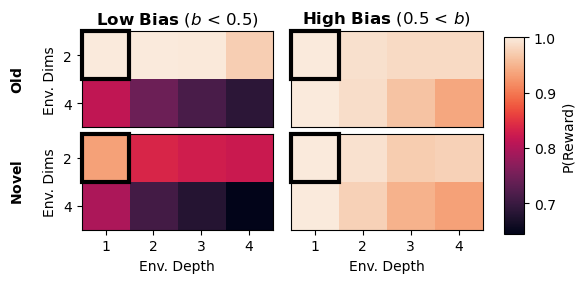

In [23]:
# Get mean accuracy for high vs low bias per environment
idx = (
    (test_summary['p_true'] == .5) &
    (test_summary['p_incidental'] == .5) &
    (test_summary['best_fit'] == 1) &
    (test_summary['model_label'] == 'ff') &
    (test_summary['ntrain'] == 1080)
)
plot_df = test_summary.loc[idx, ['depth', 'dim', 'p_reward', 'high_bias', 'novel_options']]
plot_df = plot_df.groupby(['depth', 'dim', 'high_bias', 'novel_options'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# For common color map
p_reward_bounds = [
    plot_df['p_reward'].min(),
    plot_df['p_reward'].max()
]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6.5, 3))



# Create a ScalarMappable for the colorbar
norm = Normalize(vmin=p_reward_bounds[0], vmax=p_reward_bounds[1])
sm = ScalarMappable(cmap='rocket', norm=norm)
sm.set_array([])  # Dummy array for colorbar

for i, high_bias in enumerate([0, 1]):
    for j, novel in enumerate([0, 1]):
        ax = axs[j, i]

        idx = (plot_df['high_bias'] == high_bias) & (plot_df['novel_options'] == novel)
        mat = pd.pivot(
            plot_df.loc[idx],
            index = 'dim',
            columns = 'depth',
            values = 'p_reward'
        )
        ax.imshow(
            mat,
            cmap = 'rocket',
            vmin = p_reward_bounds[0],
            vmax = p_reward_bounds[1]
        )

        depth_labels = np.unique(plot_df['depth'])
        ax.set_xticks(range(len(depth_labels)), labels=depth_labels)
        if j == 1:
            ax.set_xlabel('Env. Depth')
        else:
            ax.set_xticks([])

        if i == 1:
            ax.set_yticks([])
        else:

            dim_labels = np.unique(plot_df['dim'])
            ax.set_yticks(range(len(dim_labels)), labels=dim_labels)

        if i == 0 and j == 0:
            ax.set_ylabel(r'$\bf{Old}$'+'\n\nEnv. Dims')
        elif i == 0 and j == 1:
            ax.set_ylabel(r'$\bf{Novel}$'+'\n\nEnv. Dims')

        if high_bias and j == 0:
            ax.set_title(r'$\bf{High}$' + r' $\bf{Bias}$' + r' (0.5 < $\it{b}$)')
        elif not high_bias and j == 0:
            ax.set_title(r'$\bf{Low}$' + r' $\bf{Bias}$' + r' ($\it{b}$ < 0.5)')

        # Add an outline for the dim = 2, depth = 1 env
        rect = Rectangle(
            (0 - .5, 0 - .5), 1, 1,
            linewidth = 3,
            edgecolor = 'black',
            facecolor = 'none',
            clip_on = False
        )
        ax.add_patch(rect)


# Add a single colorbar beside the subplots
cbar = fig.colorbar(sm, ax=axs, shrink=0.85, aspect=10)
cbar.set_label('P(Reward)')

fig.tight_layout()
    
fig.subplots_adjust(right=0.75, top=0.85)

fig.savefig(f'{FIG_PATH}/test-old-heatmap-1080.pdf', dpi=300)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_37151/1435904716.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


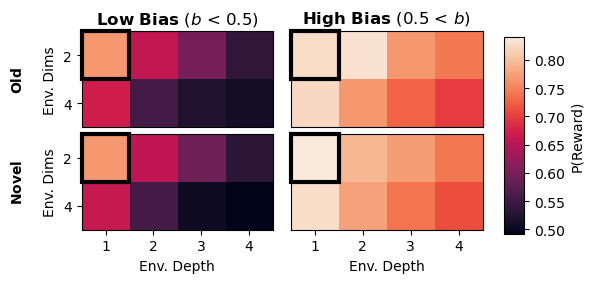

In [24]:
# Get mean accuracy for high vs low bias per environment
idx = (
    (test_summary['p_true'] == .5) &
    (test_summary['p_incidental'] == .5) &
    (test_summary['best_fit'] == 1) &
    (test_summary['model_label'] == 'ff') &
    (test_summary['ntrain'] == 72)
)
plot_df = test_summary.loc[idx, ['depth', 'dim', 'p_reward', 'high_bias', 'novel_options']]
plot_df = plot_df.groupby(['depth', 'dim', 'high_bias', 'novel_options'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# For common color map
p_reward_bounds = [
    plot_df['p_reward'].min(),
    plot_df['p_reward'].max()
]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(6.5, 3))



# Create a ScalarMappable for the colorbar
norm = Normalize(vmin=p_reward_bounds[0], vmax=p_reward_bounds[1])
sm = ScalarMappable(cmap='rocket', norm=norm)
sm.set_array([])  # Dummy array for colorbar

for i, high_bias in enumerate([0, 1]):
    for j, novel in enumerate([0, 1]):
        ax = axs[j, i]

        idx = (plot_df['high_bias'] == high_bias) & (plot_df['novel_options'] == novel)
        mat = pd.pivot(
            plot_df.loc[idx],
            index = 'dim',
            columns = 'depth',
            values = 'p_reward'
        )
        ax.imshow(
            mat,
            cmap = 'rocket',
            vmin = p_reward_bounds[0],
            vmax = p_reward_bounds[1]
        )

        depth_labels = np.unique(plot_df['depth'])
        ax.set_xticks(range(len(depth_labels)), labels=depth_labels)
        if j == 1:
            ax.set_xlabel('Env. Depth')
        else:
            ax.set_xticks([])

        if i == 1:
            ax.set_yticks([])
        else:

            dim_labels = np.unique(plot_df['dim'])
            ax.set_yticks(range(len(dim_labels)), labels=dim_labels)

        if i == 0 and j == 0:
            ax.set_ylabel(r'$\bf{Old}$'+'\n\nEnv. Dims')
        elif i == 0 and j == 1:
            ax.set_ylabel(r'$\bf{Novel}$'+'\n\nEnv. Dims')

        if high_bias and j == 0:
            ax.set_title(r'$\bf{High}$' + r' $\bf{Bias}$' + r' (0.5 < $\it{b}$)')
        elif not high_bias and j == 0:
            ax.set_title(r'$\bf{Low}$' + r' $\bf{Bias}$' + r' ($\it{b}$ < 0.5)')

        # Add an outline for the dim = 2, depth = 1 env
        rect = Rectangle(
            (0 - .5, 0 - .5), 1, 1,
            linewidth = 3,
            edgecolor = 'black',
            facecolor = 'none',
            clip_on = False
        )
        ax.add_patch(rect)


# Add a single colorbar beside the subplots
cbar = fig.colorbar(sm, ax=axs, shrink=0.85, aspect=10)
cbar.set_label('P(Reward)')


fig.tight_layout()
    
fig.subplots_adjust(right=0.75, top=0.85)

fig.savefig(f'{FIG_PATH}/test-old-heatmap-72.pdf', dpi=300)